# Ocean Cleanup Analysis and Predictive Models - Team DC20012

## Introduction

 Ocean is one of the most valuable natural resources on Earth, but also the terminal of pollution caused by humans. Since ocean cleanup is costly and time-consuming, it is necessary to take some efficient methods to release the beach pollution.

## Objective

We want to analyze and predict the human resource needed, given trashload and location statistics, to estimate and optimize resource allocation using machine learning algorithms. In this notebook, we perform data preprocessing, exploratory data analysis  as well as build prediction model to predict human resources allocation on unseen data. 

### Step 1: Import the ocean cleanup dataset and necessary libraries

In [1]:
%matplotlib inline
%pylab inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

ocean =pd.read_csv('Ocean_Dataset.csv', parse_dates= ['Cleanup Date'])
#df = pd.read_csv(file, sep = ',', parse_dates= [col],encoding='utf-8-sig', usecols= ['Date', 'ids'],)
ocean.head(10)


Populating the interactive namespace from numpy and matplotlib


,Unnamed: 0,Zone,State,Country,GPS,Cleanup Type,Cleanup Date,Group Name,Adults,Children,...,Other Trash (Clean Swell),Condoms,Diapers,Syringes,Tampons/Tampon Applicators,Personal Hygiene (Clean Swell),Foam Pieces,Glass Pieces,Plastic Pieces,Total Items Collected
0,1,"Cuyahoga County, OH, USA","Ohio, USA",United States,"41.49742, -81.56505","Land (beach, shoreline and inland)",2014-12-22,NaN,1,0,...,0,0,0,0,0,0,0,0,0,3
1,2,"Fairfax County, VA, USA","Virginia, USA",United States,"38.87456, -77.24428","Land (beach, shoreline and inland)",2014-12-24,NaN,1,0,...,0,0,0,0,0,0,0,0,2,10
2,3,"Washington, DC, USA","District of Columbia, USA",United States,"38.90733, -77.04405","Land (beach, shoreline and inland)",2015-02-19,NaN,1,0,...,1,0,0,0,0,0,0,0,0,4
3,4,"Washington, DC, USA","District of Columbia, USA",United States,"38.90733, -77.0441","Land (beach, shoreline and inland)",2015-02-19,NaN,1,0,...,0,0,0,0,0,0,0,0,0,14
4,5,"Washington, DC, USA","District of Columbia, USA",United States,"38.90728, -77.04411","Land (beach, shoreline and inland)",2015-03-10,NaN,1,0,...,2,0,0,0,0,1,0,0,1,17
5,6,"Washington, DC, USA","District of Columbia, USA",United States,"38.90745, -77.04423","Land (beach, shoreline and inland)",2015-03-10,NaN,1,0,...,0,0,0,0,0,0,0,0,1,5
6,7,"Washington, DC, USA","District of Columbia, USA",United States,"38.9074, -77.04382","Land (beach, shoreline and inland)",2015-03-18,NaN,1,0,...,0,0,0,0,0,0,0,0,0,8
7,8,"Washington, DC, USA","District of Columbia, USA",United States,"38.90756, -77.04415","Land (beach, shoreline and inland)",2015-03-24,NaN,1,0,...,0,0,0,0,0,0,0,0,2,10
8,9,"Washington, DC, USA","District of Columbia, USA",United States,"38.90738, -77.04383","Land (beach, shoreline and inland)",2015-03-24,NaN,1,0,...,4,0,0,0,0,1,0,0,0,10
9,10,"Washington, DC, USA","District of Columbia, USA",United States,"38.90735, -77.04386","Land (beach, shoreline and inland)",2015-03-24,NaN,1,0,...,1,0,0,0,0,0,0,0,0,10


In [2]:
ocean.shape

(35497, 61)

### Step 2: Data Preparation

In this step, we have split the GPS location into latitude and longitude with respect to every zone/county. Upon splitting up and getting the latitudes and longitudes as separate columns, we have extracted the state name and country name using the "Area and Census Block API"

We perform this step, because there are many empty State and Zone entries which do not have any geographical data associated with them except for the latitude and longitude

In [3]:
ocean[['Lat','Long']] = ocean.GPS.str.split(",",expand=True,)

ocean = ocean.drop(["GPS"],axis = 1)
df1 = ocean.loc[ocean["Zone"].isna()]
index_df1 = df1.index.tolist()

In [4]:
ocean.loc[ocean.Long.isna()]

,Unnamed: 0,Zone,State,Country,Cleanup Type,Cleanup Date,Group Name,Adults,Children,People,...,Diapers,Syringes,Tampons/Tampon Applicators,Personal Hygiene (Clean Swell),Foam Pieces,Glass Pieces,Plastic Pieces,Total Items Collected,Lat,Long


In [5]:
import urllib, json, requests

zone_list = []
state_list = []

str2 = ""
zone = ""
state = ""
for i in index_df1:
    zone = ""
    state = ""
    str2 = "https://geo.fcc.gov/api/census/area?lat="+str(df1["Lat"][i]).replace(" ","")+"&lon="+str(df1["Long"][i]).replace(" ","")+"&format=json"
    with urllib.request.urlopen(str2) as url:
        data = json.loads(url.read().decode())
        if len(data['results']) != 0:
            #print(data['results'][0]['county_name'])
            zone_list.append(data['results'][0]['county_name'] + " County, " + data['results'][0]['state_code'] + ", USA")
            state_list.append(data['results'][0]['state_name'] + ", USA")
            
            
        else:
            zone_list.append(0)
            state_list.append(0)
            continue

In [6]:
count = 0
for i in range(len(zone_list)):
    if zone_list[i] == 0:
        count +=1
        
print(count)

41


In [7]:
df1['Zone'] = zone_list
df1['State'] = state_list

/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
count = 0
for i in index_df1:
    ocean['Zone'][i] = zone_list[count]
    ocean['State'][i] = state_list[count]
    count = count + 1

/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In the following cell, we run a test to see if there are any more empty State or Country elements left in either of the two columns. 

In [9]:
count = 0
for i in range(len(zone_list)):
    if ocean['Zone'][i] == 0:
        count +=1
        
print(count)

0


We see that the output of the above cell is 0, which means we have successfully covered all the records in the dataset

In [10]:
ocean.shape

(35497, 62)

We convert values from Cleanup Date column from string to timestamp format.

In [11]:
try:
    ocean['Cleanup Date'] = pd.to_datetime(ocean['Cleanup Date'],format='%d/%m/%Y', errors='coerce') 
except:
    ValueError

We create three columns year, month, day extracted from the Cleanup Date column for feature engineering.

In [12]:
ocean['year']=ocean['Cleanup Date'].dt.year 
ocean['month']=ocean['Cleanup Date'].dt.month 
ocean['day']=ocean['Cleanup Date'].dt.day 

In [13]:
type(ocean['Cleanup Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

We create weekend column for feature engineering.

In [14]:
ocean['day_of_week']=ocean['Cleanup Date'].dt.dayofweek 
temp = ocean['Cleanup Date']

def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 
temp2 = ocean['Cleanup Date'].apply(applyer) 
ocean['weekend']=temp2

In [15]:
ocean.columns

Index(['Unnamed: 0', 'Zone', 'State', 'Country', 'Cleanup Type',
       'Cleanup Date', 'Group Name', 'Adults', 'Children', 'People', 'Pounds',
       'Miles', '# of bags', 'Cigarette Butts',
       'Food Wrappers (candy, chips, etc.)',
       'Take Out/Away Containers (Plastic)', 'Take Out/Away Containers (Foam)',
       'Bottle Caps (Plastic)', 'Bottle Caps (Metal)', 'Lids (Plastic)',
       'Straws, Stirrers', 'Forks, Knives, Spoons',
       'Beverage Bottles (Plastic)', 'Beverage Bottles (Glass)',
       'Beverage Cans', 'Grocery Bags (Plastic)', 'Other Plastic Bags',
       'Paper Bags', 'Cups, Plates (Paper)', 'Cups, Plates (Plastic)',
       'Cups, Plates (Foam)', 'Fishing Buoys, Pots & Traps',
       'Fishing Net & Pieces', 'Fishing Line (1 yard/meter = 1 piece)',
       'Rope (1 yard/meter = 1 piece)', 'Fishing Gear (Clean Swell)',
       '6-Pack Holders', 'Other Plastic/Foam Packaging',
       'Other Plastic Bottles (oil, bleach, etc.)', 'Strapping Bands',
       'Tobacco Pac

### Step3: Time Series Analysis for Total Items Collected

/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


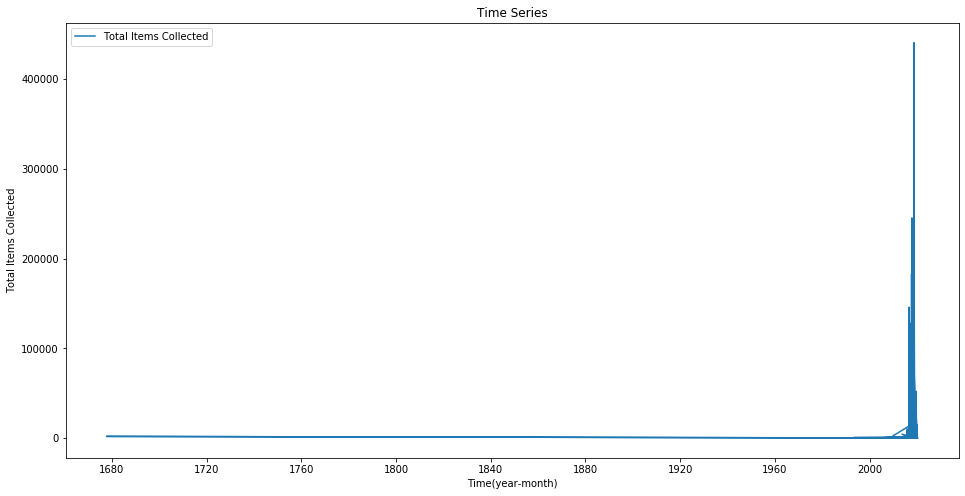

In [16]:
ocean.index = ocean['Cleanup Date'] # indexing the Datetime to get the time period on the x-axis. 
ocean=ocean.drop('Unnamed: 0',1) 
ts = ocean['Total Items Collected'] 
plt.figure(figsize=(16,8)) 
plt.plot(ts, label='Total Items Collected') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("Total Items Collected") 
plt.legend(loc='best')

We notice that there are data from a very long time ago. We remove irrelevant/wrong date data and only use data within 5 years (from 2015 to 2019) (35304 out of 35497 records).

In [17]:
ocean.dropna(subset=['Cleanup Date'], inplace=True)

In [18]:
ocean['Cleanup Date'].isnull().sum()

0

In [19]:
ocean = ocean.loc[(ocean['Cleanup Date'] > '31/12/2014' ) & (ocean['Cleanup Date'] < '01/01/2020')]

In [20]:
ocean = ocean[(ocean.People != 10000)]


In [21]:
ocean.shape

(35304, 66)

In [22]:
ocean = ocean.drop_duplicates()

In [23]:
ocean.shape

(35290, 66)

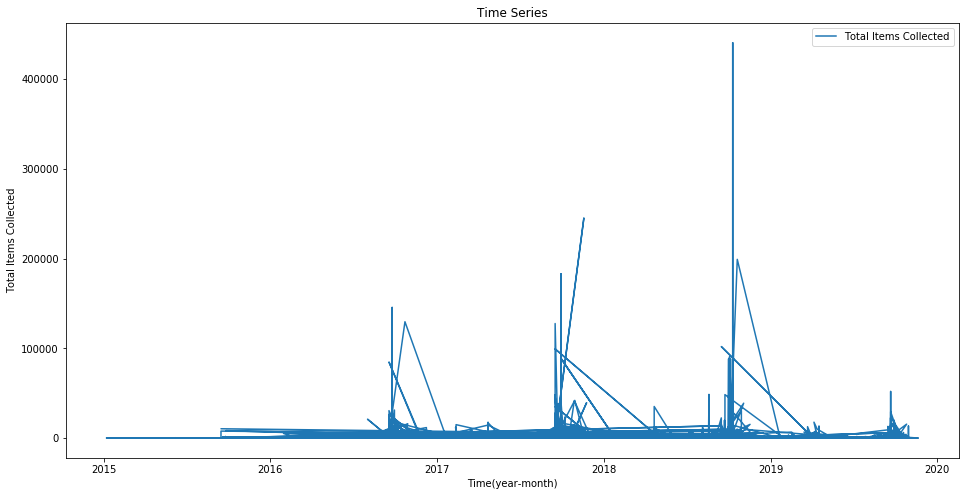

In [24]:
ocean.index = ocean['Cleanup Date'] # indexing the Datetime to get the time period on the x-axis. 
    
ts = ocean['Total Items Collected'] 
plt.figure(figsize=(16,8)) 
plt.plot(ts, label='Total Items Collected') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("Total Items Collected") 
plt.legend(loc='best')

### Step4: Overview for Beach Cleanup Performance per Year

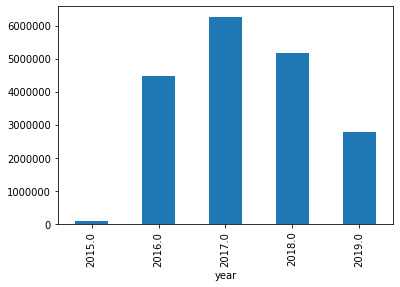

In [25]:
ocean.groupby('year')['Total Items Collected'].sum().plot.bar()

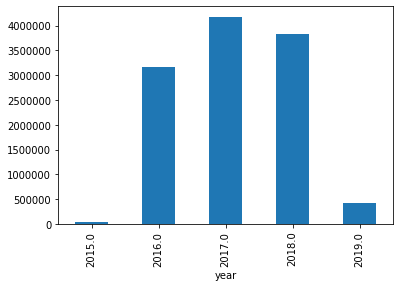

In [26]:
ocean.groupby('year')['Pounds'].sum().plot.bar()

In [27]:
ocean['Zone'].isnull().sum()

0

In [28]:
ocean['State_2'] = ocean.Zone.str[-7:]

In [29]:
ocean['State'] = ocean['State'].astype('category')
cat_columns = ocean.select_dtypes(['category']).columns
ocean[cat_columns] = ocean[cat_columns].apply(lambda x: x.cat.codes)

In [30]:
(ocean['People']==0).sum()

57

In [31]:
ocean = ocean[ocean.People != 0]

In [32]:
(ocean['People']==0).sum()

0

In [33]:
del ocean['Cleanup Date']

In [34]:
ocean = ocean.loc[(ocean['Pounds']/ocean['People'] < 16)]

In [35]:
ocean = ocean.reset_index()

In [36]:
ocean.shape

(31546, 67)

## Step 5: Model training and evaluation

We investigate various approaches: generalized linear models (L1, L2) and Xgboost. The performance of each method will be evaluated by computing the errors (RMSE) between the predicted resources and the ground-truth resources on a held-out dataset. Ultimately, the prediction model can be interpreted as part of a resource recommendation system that will be potentially helpful for environmentalists to optimize human resource recruitment in their campaigns. The best method is Xgboost (RMSE = 83.57), better than the baseline (RMSE =163.47).

In [37]:
ocean_normalizing = ocean.iloc[:,9:59]
ocean_normalizing.reset_index()
ocean_normalizing_columns = ocean_normalizing.columns

In [38]:
from sklearn import preprocessing

x = ocean_normalizing.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
ocean_normalized = pd.DataFrame(x_scaled, columns = ocean_normalizing_columns)

In [39]:
ocean_normalized['People'] = ocean['People']
ocean_normalized['weekend'] = ocean['weekend']
ocean_normalized['month'] = ocean['month']

In [40]:
!conda install -c anaconda py-xgboost --yes

Solving environment: done

# All requested packages already installed.



In [41]:
train = ocean_normalized[:26622]
test = ocean_normalized[26623:]

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor, plot_importance 
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
from sklearn import metrics
import random 
random.seed(1234)
np.random.seed(1234)

def training (data, predictors, outcome, method):
    if method == 'linear_regression':
        train_model = LinearRegression()
    elif method == 'ridge_regression':
        train_model = Ridge(alpha=0.001)
#         train_model = ElasticNet(alpha=0.05, l1_ratio=0)
    elif method == 'lasso_regression':
        train_model = ElasticNet(alpha=0.001, l1_ratio=1, normalize=True)
    elif method == 'Xgboost':
        train_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
        
        
# Fit the model:
    train_model.fit(data[predictors], data[outcome])

    # Make predictions on the training set:
    predictions = train_model.predict(data[predictors])

    # How well the model fits the training data
    print(method, 'Training RMSE: ', np.sqrt(metrics.mean_squared_error(data[outcome], predictions)))

    #Perform k-fold cross-validation with 10 folds:
    kf = KFold(n_splits=10, random_state=None, shuffle=False)
    error = []

    for train_split, test_split in kf.split(data[predictors]): 
        
        # Filter the training set:
        train_predictors = data[predictors].iloc[train_split, :]
        
        # Filter the target that we are using to train the algorithm:
        train_target = data[outcome].iloc[train_split]

        # Training the algorithm using the predictors and target:
        train_model.fit(train_predictors, train_target)

        test_predictors = data[predictors].iloc[test_split, :]
        test_target = data[outcome].iloc[test_split]
        test_predictions = train_model.predict(test_predictors)

        error.append(np.sqrt(metrics.mean_squared_error(test_predictions, test_target)))
    # How well the model performs on unseen data (not used in train_model.fit())
    print (method, "Cross-Validation RMSE :", np.mean(error))

    # Fit the model again so that it can be refered outside the function:
    train_model.fit(data[predictors],data[outcome])
    return train_model
    
    
def testing(data, predictors, model):
    return model.predict(data[predictors])

outcome_var = 'People'
predictor_var = ['Total Items Collected', 'month', 'weekend', 'Pounds', 'Miles', 'Plastic Pieces', 'Foam Pieces', 'Glass Pieces']

method = 'linear_regression'
train_model = training(train, predictor_var, outcome_var, method)
predictions_1 = testing(test, predictor_var, train_model)

method = 'ridge_regression'
train_model = training(train, predictor_var, outcome_var, method)
predictions_2 = testing(test, predictor_var, train_model)

method = 'lasso_regression'
train_model = training(train, predictor_var, outcome_var, method)
predictions_3 = testing(test, predictor_var, train_model)

method = 'Xgboost'
train_model = training(train, predictor_var, outcome_var, method)
predictions_4 = testing(test, predictor_var, train_model)

linear_regression Training RMSE:  97.39151877768143
linear_regression Cross-Validation RMSE : 86.80289738795292
ridge_regression Training RMSE:  97.39152709703193
ridge_regression Cross-Validation RMSE : 86.71876711627023
lasso_regression Training RMSE:  97.39457253125843
lasso_regression Cross-Validation RMSE : 86.76911709966538
[12:10:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Xgboost Training RMSE:  42.801894214651995
[12:10:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:10:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:10:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:11:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:11:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:11:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:11:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:12:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:12:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:12:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Xgboost Cross-Validation RMSE : 83.56967693018632
[12:12:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/khanhhuyen4523/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


## Step 6: Model Validation

Baseline is the RMSE of a basic model predicting by using the average number of people in each record. 

In [42]:
a_mean = ocean_normalized.People.mean()
n = ocean_normalized.People.count()
err_mean_sq = 0
for i in ocean_normalized.People:
    err_mean_sq += (i-a_mean)**2/n
RMSE_base = np.sqrt(err_mean_sq)
print(RMSE_base) 
print(a_mean)
print(n)

163.4723686045661
17.22082038927281
31546


The plot below compares the actual numbers of people participated in ocean cleanup actitivies in the test set (unseen data) to the predicted numbers of Xgboost methods.

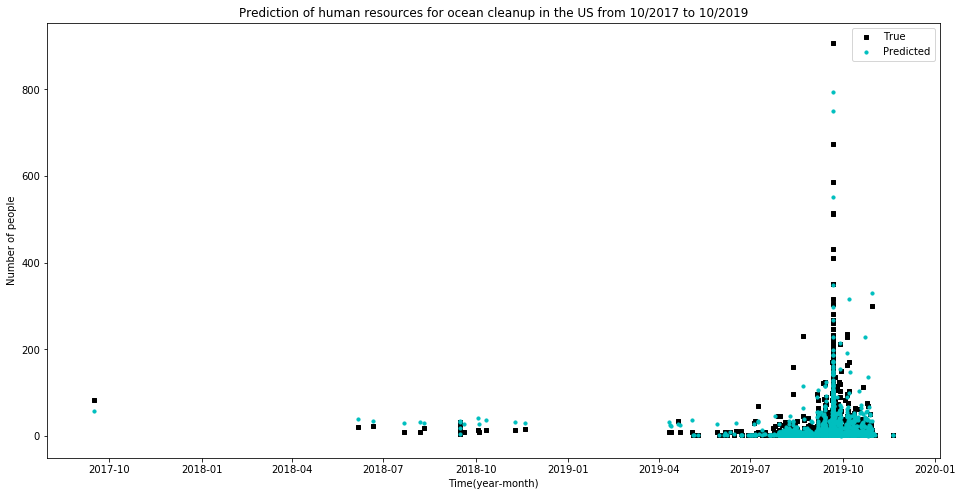

In [43]:
plt.figure(figsize=(16,8)) 

t = ocean['Cleanup Date'][26623:]
a = ocean['People'][26623:]
b = predictions_4

ax = subplot(111)
ax.scatter(t, a, s=10, c='k', marker="s", label="True")
ax.scatter(t, b, s=10, c='c', marker="o", label="Predicted")
 
plt.xlabel("Time(year-month)") 
plt.ylabel("Number of people") 
plt.title('Prediction of human resources for ocean cleanup in the US from 10/2017 to 10/2019')
plt.legend(loc='best')
plt.show()